# Abstimmungsfaktor Agglomerationen

In [439]:
# import libraries
import pandas as pd
import numpy as np
from pyaxis import pyaxis
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# from datetime import datetime
# import re
# import os
# import json
# import requests

In [389]:
# import data
Abstimmungsresultate_URL = 'https://www.bfs.admin.ch/bfsstatic/dam/assets/12567434/master'
px = pyaxis.parse(Abstimmungsresultate_URL, encoding='ISO-8859-2')

In [127]:
agglomerationen = pd.read_excel("input/Raumgliederungen.xlsx", skiprows=1)[1:]

In [430]:
kennzahlen = pd.read_excel("input/je-d-21.03.01.xlsx", skiprows=5)[3:2205]

---

### Daten aufbereiten

In [233]:
data = px['DATA'].set_index(["Datum und Vorlage", "Kanton (-) / Bezirk (>>) / Gemeinde (......)", "Ergebnis"]).unstack(level=-1).reset_index()

In [234]:
data.columns = ['Datum und Vorlage', 'Regionsbezeichnung', 'Abgegebene Stimmen', 'Beteiligung in %', 'Gültige Stimmzettel', 'Ja','Ja in %', 'Nein','Stimmberechtigte']
data = data.replace('"..."', np.nan)

In [235]:
lookup_table = pd.DataFrame.from_dict({"code": px['METADATA']['CODES(Kanton (-) / Bezirk (>>) / Gemeinde (......))'], "description" : px['METADATA']['VALUES(Kanton (-) / Bezirk (>>) / Gemeinde (......))']})

In [236]:
data['Code'] = data['Regionsbezeichnung'].map(lookup_table.set_index('description').code)

In [238]:
data_gdes = data[(data.Code.str.len() == 4)]
data_ch = data[data['Regionsbezeichnung'] == 'Schweiz']

In [239]:
data_gdes.Code = data_gdes.Code.astype(int)
agglomerationen['BFS Gde-nummer'] = agglomerationen['BFS Gde-nummer'].astype(int)

In [240]:
data_gdes = data_gdes.merge(agglomerationen, left_on="Code", right_on="BFS Gde-nummer", how="left")

In [241]:
data_gdes = data_gdes[~pd.isnull(data_gdes['BFS Gde-nummer'])]

In [ ]:
data_gdes['Datum'] = pd.to_datetime(data_gdes['Datum und Vorlage'].str[0:10])
data_gdes_valid = data_gdes[data_gdes.Datum > "1981-04-05"]

Agglomerationen:
- Städtische Arbeitsplatzgemeinde einer grossen Agglomeration (112)
- Städtische Wohngemeinde einer grossen Agglomeration (113)
- Städtische Arbeitsplatzgemeinde einer mittelgrossen Agglomeration (122)
- Städtische Wohngemeinde einer mittelgrossen Agglomeration (123)

https://www.atlas.bfs.admin.ch/maps/13/de/12359_12482_3191_227/20387.html

In [408]:
data_gdes_valid["municipality_type"] = 0

In [431]:
# Agglomerationen als Typ 1 codieren
data_gdes_valid.loc[data_gdes["Gemeindetypologie 2012 (25 Typen)"].astype(int).isin([112, 113, 122, 123]), "municipality_type"] = 1
# Städte als Typ 2 codieren
data_gdes_valid.loc[data_gdes["Gemeindetypologie 2012 (25 Typen)"].astype(int).isin([111, 121]), "municipality_type"] = 2

---

## Auswertung nach Gemeindetyp

- Agglomeration: municipality_type = 1
- Städte: municipality_type = 2
- Alles andere:  municipality_type = 0

In [410]:
results_agglos = []
for Vorlage in data_gdes_valid['Datum und Vorlage'].unique():
    yes = data_gdes_valid[(data_gdes_valid['Datum und Vorlage'] == Vorlage) & (data_gdes_valid.municipality_type == 1)].Ja.astype(float).sum()
    no = data_gdes_valid[(data_gdes_valid['Datum und Vorlage'] == Vorlage)  & (data_gdes_valid.municipality_type == 1)].Nein.astype(float).sum()
    results_agglos.append([Vorlage, 100 /(yes + no)*yes])
results_agglos = pd.DataFrame(results_agglos)

In [411]:
results_agglos = results_agglos.merge(data_ch[['Datum und Vorlage', 'Ja in %']], left_on=0, right_on="Datum und Vorlage", how="left")

In [412]:
results_agglos['angenommen_ch'] = results_agglos['Ja in %'].astype(float) > 50
results_agglos['angenommen_agglo'] = results_agglos[1].astype(float) > 50
results_agglos['quota_agglo'] = results_agglos.angenommen_agglo == results_agglos.angenommen_ch

In [413]:
results_agglos['quota_agglo'].value_counts(normalize=True)

True     0.981818
False    0.018182
Name: quota_agglo, dtype: float64

In [414]:
results_cities = []
for Vorlage in data_gdes_valid['Datum und Vorlage'].unique():
    yes = data_gdes_valid[(data_gdes_valid['Datum und Vorlage'] == Vorlage) & (data_gdes_valid.municipality_type == 2)].Ja.astype(float).sum()
    no = data_gdes_valid[(data_gdes_valid['Datum und Vorlage'] == Vorlage)  & (data_gdes_valid.municipality_type == 2)].Nein.astype(float).sum()
    results_cities.append([Vorlage, 100 /(yes + no)*yes])
results_cities = pd.DataFrame(results_cities)

In [415]:
results_cities = results_cities.merge(data_ch[['Datum und Vorlage', 'Ja in %']], left_on=0, right_on="Datum und Vorlage", how="left")

In [416]:
results_cities['angenommen_ch'] = results_cities['Ja in %'].astype(float) > 50
results_cities['angenommen_city'] = results_cities[1].astype(float) > 50
results_cities['quota_city'] = results_cities.angenommen_city == results_cities.angenommen_ch

In [417]:
results_cities['quota_city'].value_counts(normalize=True)

True     0.890909
False    0.109091
Name: quota_city, dtype: float64

In [418]:
results_rural = []
for Vorlage in data_gdes_valid['Datum und Vorlage'].unique():
    yes = data_gdes_valid[(data_gdes_valid['Datum und Vorlage'] == Vorlage) & (data_gdes_valid.municipality_type == 0)].Ja.astype(float).sum()
    no = data_gdes_valid[(data_gdes_valid['Datum und Vorlage'] == Vorlage)  & (data_gdes_valid.municipality_type == 0)].Nein.astype(float).sum()
    results_rural.append([Vorlage, 100 /(yes + no)*yes])
results_rural = pd.DataFrame(results_rural)

In [419]:
results_rural = results_rural.merge(data_ch[['Datum und Vorlage', 'Ja in %']], left_on=0, right_on="Datum und Vorlage", how="left")

In [420]:
results_rural['angenommen_ch'] = results_rural['Ja in %'].astype(float) > 50
results_rural['angenommen_rural'] = results_rural[1].astype(float) > 50
results_rural['quota_rural'] = results_rural.angenommen_rural== results_rural.angenommen_ch

In [421]:
results_rural['quota_rural'].value_counts(normalize=True)

True     0.912121
False    0.087879
Name: quota_rural, dtype: float64

---

## PCA

In [437]:
data_pca = data_gdes_valid[['Datum und Vorlage', 'Gemeindename', 'Ja in %']].pivot(index="Gemeindename", columns="Datum und Vorlage", values='Ja in %')

In [438]:
data_pca

Datum und Vorlage,1981-06-14 Bundesbeschluss über die Volksinitiative ŤGleiche Rechte für Mann und Frauť,1981-06-14 Bundesbeschluss über die Volksinitiative Ťzur Absicherung der Rechte der Konsumentenť,1981-11-29 Bundesbeschluss über die Weiterführung der Finanzordnung und die Verbesserung des Bundeshaushaltes,1982-06-06 Ausländergesetz,1982-06-06 Schweizerisches Strafgesetzbuch (Gewaltverbrechen),1982-11-28 Gegenentwurf zur Volksinitiative Ťzur Verhinderung missbräuchlicher Preiseť,1982-11-28 Volksinitiative Ťzur Verhinderung missbräuchlicher Preiseť,1983-02-27 Bundesbeschluss über den Energieartikel in der Bundesverfassung,1983-02-27 Bundesbeschluss über die Neuregelung bei den Treibstoffzöllen,1983-12-04 Bundesbeschluss über die Erleichterung gewisser Einbürgerungen,...,2018-09-23 Volksinitiative ŤFür Ernährungssouveränität. Die Landwirtschaft betrifft uns alleť,2018-09-23 Volksinitiative ŤFür gesunde sowie umweltfreundlich und fair hergestellte Lebensmittel (Fair-Food-Initiative)ť,2018-11-25 Volksinitiative ŤFür die Würde der landwirtschaftlichen Nutztiere (Hornkuh-Initiative)ť,2018-11-25 Volksinitiative ŤSchweizer Recht statt fremde Richter (Selbstbestimmungsinitiative)ť,2018-11-25 Änderung des Bundesgesetzes über den Allgemeinen Teil des Sozialversicherungsrechts (ATSG) (Gesetzliche Grundlage für die Überwachung von Versicherten),2019-02-10 Volksinitiative ŤZersiedelung stoppen - für eine nachhaltige Siedlungsentwicklung (Zersiedelungsinitiative)ť,2019-05-19 Bundesbeschluss über die Genehmigung und die Umsetzung des Notenaustauschs zwischen der Schweiz und der EU betreffend die Übernahme der Richtlinie (EU) 2017/853 zur Änderung der EU-Waffenrichtlinie (Weiterentwicklung des Schengen-Besitzstands),2019-05-19 Bundesgesetz über die Steuerreform und die AHV-Finanzierung (STAF),2020-02-09 Volksinitiative vom 18. Oktober 2016 ŤMehr bezahlbare Wohnungenť,2020-02-09 Änderung vom 14. Dezember 2018 des Strafgesetzbuches und des Militärstrafgesetzes (Diskriminierung und Aufruf zu Hass aufgrund der sexuellen Orientierung)
Gemeindename,,,,,,,,,,,,,,,,,,,,,
Aadorf,46.6478476,36.8159204,66.122449,47.0014993,68.4407796,70.6132879,49.3975904,51.8588532,47.515528,48.2835821,...,22.2492697,27.6465028,38.3761277,41.046832,75.1485884,32.337505,60.7275734,62.9927936,30.1619433,50.605449
Aarau,55.9835879,64.4259644,73.7214363,52.2399588,65.3346908,25.8361461,54.6023965,46.6139397,45.3323558,40.637776,...,27.8280916,37.6585366,44.5813461,25.0416934,59.6477596,40.4710145,74.7987707,68.082253,45.798616,69.1114245
Aarberg,57.6168929,57.6399395,67.5170068,56.5064478,67.9069767,30.3030303,42.8571429,43.9461883,49.6296296,43.375,...,19.5710456,27.2646536,41.220339,35.7674104,70.9482179,29.9103504,59.5431098,61.1069559,33.7192475,56.8443804
Aarburg,55.334728,73.5632184,77.6849642,41.3161465,55.2258935,25.3144654,66.8822768,47.9166667,49.6683861,32.2616408,...,22.6039783,29.1853178,47.2451791,40.4109589,70.6521739,40.2394107,57.9136691,60.2909091,41.8660287,56.5079365
Aarwangen,61.6161616,71.8592965,56.3279857,43.3566434,47.3255814,22.8417266,59.7039474,39.2561983,44.3228454,36.9736842,...,20.524836,27.4766355,38.8811189,45.3665284,75.2071823,28.6808511,49.7097242,59.6350365,30.6743421,52.8735632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zwieselberg,52.3809524,73.8095238,86.2745098,35.1648352,58.6956522,44.4444444,37.5,59.1836735,63.2653061,52.5423729,...,31.5068493,40,46.9565217,47.8632479,69.9115044,32.5581395,36.2745098,55,31.8681319,40.8602151
Zwingen,61.1111111,79.0123457,57.3333333,41.9354839,60.2094241,14.9805447,72.4271845,37.7880184,41.4746544,47.4358974,...,27.3809524,33.6283186,54.797048,44.2379182,72.3443223,33.5766423,45.8677686,50.1048218,37.4774775,54.9371634
Zwischbergen,43.902439,57.5,62.745098,31.147541,45.1612903,11.3636364,63.0434783,66.0714286,85.7142857,23.880597,...,0,10.3448276,88.5714286,83.3333333,91.6666667,20,9.6774194,32.2580645,0,24.137931


In [468]:
X_std = StandardScaler().fit_transform(data_pca.dropna())

In [447]:
pd.DataFrame(X_std)

,0,1,2,3,4,5,6,7,8,9,...,320,321,322,323,324,325,326,327,328,329
0,-0.621485,-1.422289,0.056061,-0.157725,0.523838,4.382171,-0.154927,0.241042,-0.658976,0.592130,...,-0.684986,-0.686499,-0.257782,0.269908,0.820435,0.016912,0.486636,-0.269846,-0.497674,-0.598644
1,0.065457,0.515747,0.820349,0.277503,0.224512,-0.123636,0.221169,-0.172288,-0.835098,-0.139112,...,-0.315972,-0.020095,0.340896,-1.212893,-0.749879,0.992756,1.581374,0.261978,0.985104,0.831474
2,0.185639,0.039414,0.196322,0.631976,0.472397,0.325855,-0.627535,-0.382522,-0.488426,0.122675,...,-0.862139,-0.711915,0.016627,-0.219206,0.394915,-0.274294,0.394485,-0.466907,-0.160346,-0.116507
3,0.017713,1.157120,1.218992,-0.630081,-0.749647,-0.176131,1.108505,-0.069625,-0.485300,-0.940202,...,-0.661524,-0.584075,0.597901,0.210998,0.364925,0.964969,0.267715,-0.552180,0.612189,-0.142507
4,0.479913,1.037516,-0.929044,-0.460551,-1.510980,-0.424956,0.589804,-0.752120,-0.916538,-0.489544,...,-0.799050,-0.697805,-0.209061,0.670108,0.826370,-0.421807,-0.370551,-0.620716,-0.449085,-0.423367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,-0.199632,1.174408,2.082909,-1.141152,-0.415275,1.748869,-1.014639,0.818279,0.611598,0.999439,...,-0.072639,0.135754,0.570052,0.901417,0.289891,0.043383,-1.415810,-1.105055,-0.335881,-1.351742
2198,0.442751,1.539611,-0.827929,-0.578625,-0.269397,-1.216006,1.509177,-0.867821,-1.146309,0.511057,...,-0.345548,-0.288347,1.326503,0.565547,0.536348,0.165582,-0.669455,-1.616578,0.196036,-0.263895
2199,-0.823497,0.029592,-0.283626,-1.474921,-1.719548,-1.579966,0.831116,1.361074,2.422615,-1.741762,...,-2.156677,-1.838103,4.585045,4.187555,2.493801,-1.463320,-3.485061,-3.481479,-3.357839,-2.644018
2200,-0.311756,0.101380,-0.170049,-0.790559,0.907714,0.721935,-0.643255,-0.549079,-0.266470,-0.020008,...,-0.512174,-0.436335,-0.416526,0.445202,-0.123087,0.367753,-0.502879,-0.801344,-0.283541,-0.671958


In [475]:
# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit(X_std)

[]

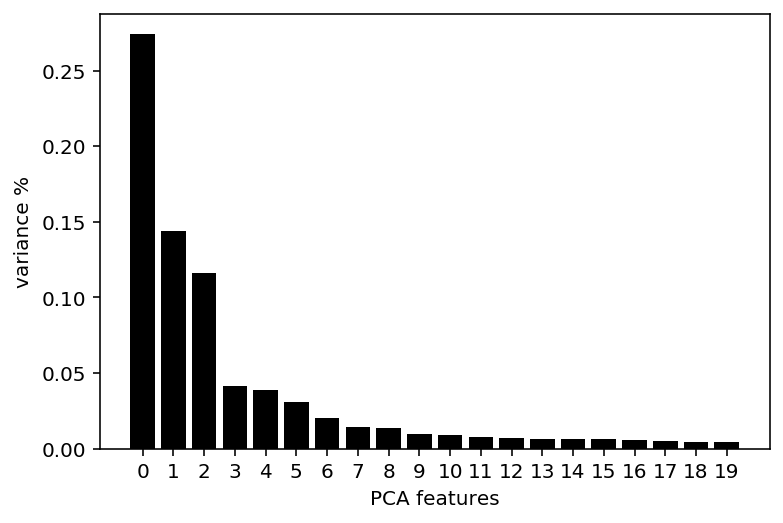

In [476]:
# Plot the explained variances
%config InlineBackend.figure_format='retina'
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.plot()

In [481]:
pca = PCA(n_components=2)
principalComponents = pca.fit(X_std)

Text(0, 0.5, 'PCA 2')

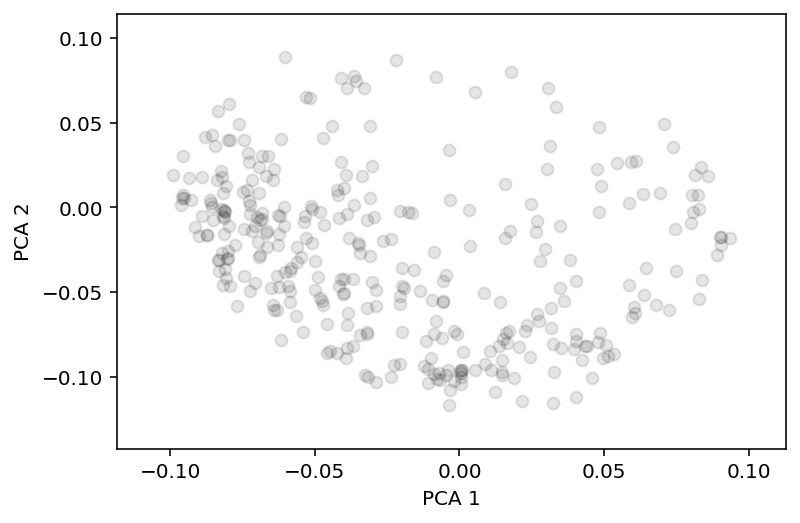

In [484]:
plt.scatter(principalComponents.components_[0], principalComponents.components_[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')